In [1]:
!tar -xvf /content/images.tar
# Dog Breeds assigned ==> Chow, Boxer, Bedlington Terrier, Bluetick

Images/
Images/n02085620-Chihuahua/
Images/n02085620-Chihuahua/n02085620_10621.jpg
Images/n02085620-Chihuahua/n02085620_10976.jpg
Images/n02085620-Chihuahua/n02085620_11238.jpg
Images/n02085620-Chihuahua/n02085620_11258.jpg
Images/n02085620-Chihuahua/n02085620_11337.jpg
Images/n02085620-Chihuahua/n02085620_1152.jpg
Images/n02085620-Chihuahua/n02085620_11696.jpg
Images/n02085620-Chihuahua/n02085620_11818.jpg
Images/n02085620-Chihuahua/n02085620_11948.jpg
Images/n02085620-Chihuahua/n02085620_1205.jpg
Images/n02085620-Chihuahua/n02085620_12334.jpg
Images/n02085620-Chihuahua/n02085620_1235.jpg
Images/n02085620-Chihuahua/n02085620_1298.jpg
Images/n02085620-Chihuahua/n02085620_13151.jpg
Images/n02085620-Chihuahua/n02085620_1321.jpg
Images/n02085620-Chihuahua/n02085620_13383.jpg
Images/n02085620-Chihuahua/n02085620_1346.jpg
Images/n02085620-Chihuahua/n02085620_14413.jpg
Images/n02085620-Chihuahua/n02085620_14516.jpg
Images/n02085620-Chihuahua/n02085620_1455.jpg
Images/n02085620-Chihuahua/n020

In [2]:
!ls


Images	images.tar  lists.tar  sample_data


In [16]:
!tar -xvf /content/lists.tar
!ls

file_list.mat
train_list.mat
test_list.mat
annotation.tar	Images	    lists.tar	 test_list.mat
file_list.mat	images.tar  sample_data  train_list.mat


In [18]:
!tar -xvf /content/annotation.tar
!ls

Streaming output truncated to the last 5000 lines.
Annotation/n02108089-boxer/n02108089_1571
Annotation/n02108089-boxer/n02108089_1575
Annotation/n02108089-boxer/n02108089_1619
Annotation/n02108089-boxer/n02108089_1626
Annotation/n02108089-boxer/n02108089_1654
Annotation/n02108089-boxer/n02108089_1672
Annotation/n02108089-boxer/n02108089_1675
Annotation/n02108089-boxer/n02108089_1690
Annotation/n02108089-boxer/n02108089_1748
Annotation/n02108089-boxer/n02108089_1757
Annotation/n02108089-boxer/n02108089_1775
Annotation/n02108089-boxer/n02108089_1859
Annotation/n02108089-boxer/n02108089_1912
Annotation/n02108089-boxer/n02108089_1956
Annotation/n02108089-boxer/n02108089_200
Annotation/n02108089-boxer/n02108089_2007
Annotation/n02108089-boxer/n02108089_2056
Annotation/n02108089-boxer/n02108089_2106
Annotation/n02108089-boxer/n02108089_2355
Annotation/n02108089-boxer/n02108089_2360
Annotation/n02108089-boxer/n02108089_2367
Annotation/n02108089-boxer/n02108089_2432
Annotation/n02108089-boxer

In [20]:
import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
from PIL import Image
import keras,cv2,shutil,keras_preprocessing,requests,math,glob, datetime
import tensorflow as tf
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Lambda, Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, SpatialDropout2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocessor
from keras.applications.xception import Xception, preprocess_input as xception_preprocessor
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inc_resnet_preprocessor
from keras.applications.nasnet import NASNetLarge, preprocess_input as nasnet_preprocessor
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import load_files
from io import BytesIO
import seaborn as sns
import xml.etree.ElementTree as ET
from pathlib import Path
%load_ext tensorboard
shutil.rmtree('./logs', ignore_errors=True)



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [67]:
import glob
import os

In [94]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

annots = [
    '/content/Images/n02085620-Chihuahua',
    '/content/Images/n02085782-Japanese_spaniel'
]


breed_paths =  [
    '/content/Annotation/n02088632-bluetick/',
    '/content/Annotation/n02093647-Bedlington_terrier/',
    '/content/Annotation/n02112137-chow/',
    '/content/Annotation/n02108089-boxer/'
]



dog_images_paths = [
    '/content/Images/n02085782-Japanese_spaniel/',
    '/content/Images/n02085620-Chihuahua/'
]

# Check if each folder exists and count image files
for folder_path in annots:
    if os.path.exists(folder_path):
        files = os.listdir(folder_path)
        image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
        print(f"Number of image files in '{folder_path}': {len(image_files)}")
    else:
        print(f"Folder '{folder_path}' does not exist.")

for folder_path in breed_paths:
    if os.path.exists(folder_path):
        files = os.listdir(folder_path)
        print(f"Number of image files in '{folder_path}': {len(files)}")
    else:
        print(f"Folder '{folder_path}' does not exist.")

for folder_path in dog_images_paths:
    if os.path.exists(folder_path):
        files = os.listdir(folder_path)
        print(f"Number of image files in '{folder_path}': {len(files)}")
    else:
        print(f"Folder '{folder_path}' does not exist.")




cropped = "./Cropped/"
img_size = 100 # 100 x 100
train_dir = './Cropped'
batch_size_training = 256
batch_size_validation = 256
input_shape = (img_size,img_size,3)

######## Plot Metrics Function ########
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

######## Read X and Y coordinate ranges from an annotation ########
def get_bounding_boxes(annots):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

######## Get image path from annotation path ########
def get_image(annots):
    img_path = '/content/Images'
    file = annots.split('/')
    img_filename = img_path + file[-2]+'/'+file[-1]+'.jpg'
    return img_filename

######## Fill image with black to make a square (not used) ########
def make_square(im, min_size=100, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

######## Preprocess and get predictions from data with a pretrained model ########
def get_features(model_name, model_preprocessor, input_size, data):
    input_layer = keras.layers.Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)
    feature_extractor = Model(inputs = input_layer, outputs = GlobalAveragePooling2D()(base_model))
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

######## Concatenate all predictions on data for all pretrained models ########
def extract_all_features(data):
    inception_features = get_features(InceptionV3, inception_preprocessor, input_shape, data)
    xception_features = get_features(Xception, xception_preprocessor, input_shape, data)
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, input_shape, data)
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, input_shape, data)
    extracted_features = np.concatenate([inception_features, xception_features, nasnet_features, inc_resnet_features],axis=-1)
    return extracted_features


Number of image files in '/content/Images/n02085620-Chihuahua/': 152
Number of image files in '/content/Images/n02085782-Japanese_spaniel/': 16
Number of image files in '/content/Annotation/n02088632-bluetick/': 171
Number of image files in '/content/Annotation/n02093647-Bedlington_terrier/': 182
Number of image files in '/content/Annotation/n02112137-chow/': 196
Number of image files in '/content/Annotation/n02108089-boxer/': 151
Number of image files in '/content/Images/n02085782-Japanese_spaniel/': 16
Number of image files in '/content/Images/n02085620-Chihuahua/': 152


In [103]:

plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.axis("off")
    dog = get_image(dog_images_paths[i])
    im = Image.open(dog)
    im = im.resize((100, 100), Image.ANTIALIAS)
    plt.imshow(im)

<Figure size 1000x600 with 0 Axes>
<
...
>


In [101]:
plt.figure(figsize=(10,6))
for i in range(len(dog_images)):
    bbox = get_bounding_boxes(annotations[i])
    dog = get_image(annotations[i])
    im = Image.open(dog)
    for j in range(len(bbox)):
        im2 = im.crop(bbox[j])
        im2 = im2.resize((331,331), Image.ANTIALIAS)
        new_path = dog.replace(dog_images_paths,'./Cropped/')
        new_path = new_path.replace('.jpg','-' + str(j) + '.jpg')
        im2=im2.convert('RGB')
        head, tail = os.path.split(new_path)
        Path(head).mkdir(parents=True, exist_ok=True)
        im2.save(new_path)

<Figure size 1000x600 with 0 Axes>

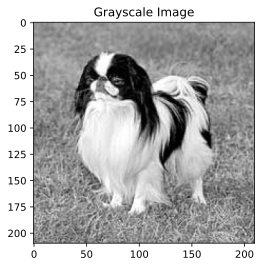

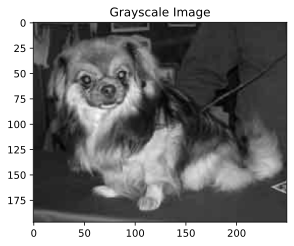

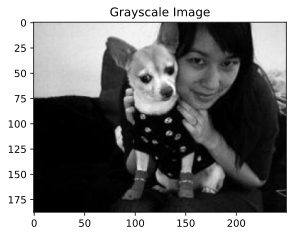

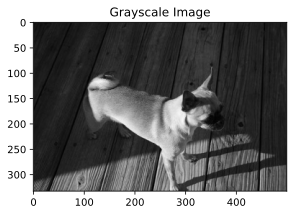

In [108]:
#converting image colors to greyscale
for class_folder in dog_images_paths:
    # Get a list of image files in the class folder
    image_files = os.listdir(class_folder)

    # Pick two images from each class
    num_images_to_pick = 2
    for i in range(min(num_images_to_pick, len(image_files))):
        image_file = image_files[i]
        image_path = os.path.join(class_folder, image_file)

        # Load the image in color
        color_image = cv2.imread(image_path)

        # Convert the color image to grayscale
        grayscale_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

        output_path = os.path.join(class_folder, f'grayscale_{i+1}.jpg')
        cv2.imwrite(output_path, grayscale_image)

        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 2)
        plt.imshow(grayscale_image, cmap='gray')
        plt.title('Grayscale Image')

        plt.show()



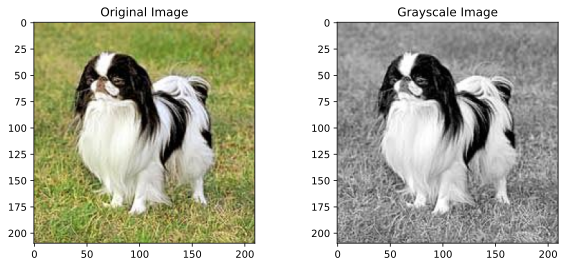

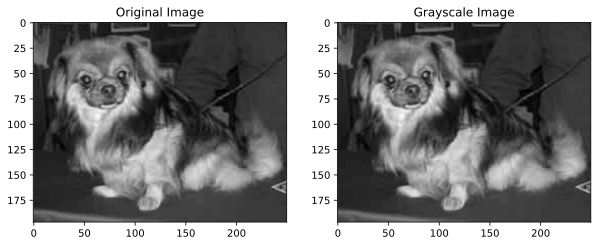

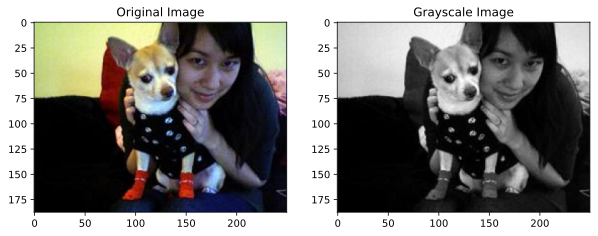

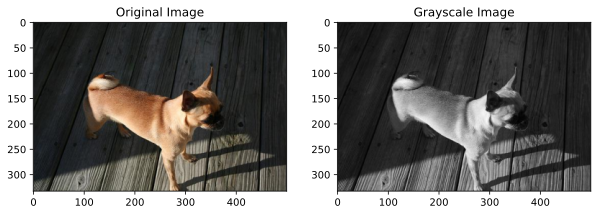

In [107]:

# Loop through each class folder
for class_folder in dog_images_paths:
    # Get a list of image files in the class folder
    image_files = os.listdir(class_folder)

    # Pick two images from each class
    num_images_to_pick = 2
    for i in range(min(num_images_to_pick, len(image_files))):
        image_file = image_files[i]
        image_path = os.path.join(class_folder, image_file)

        # Load the image in color
        color_image = cv2.imread(image_path)

        # Convert the color image to grayscale
        grayscale_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

        # Plot the color and grayscale images side by side
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(grayscale_image, cmap='gray')
        plt.title('Grayscale Image')

        plt.show()


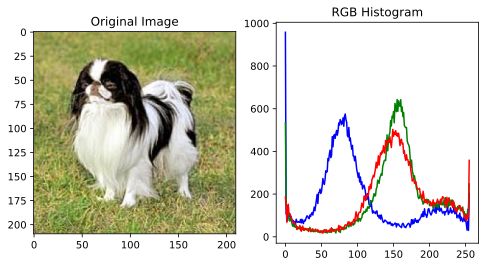

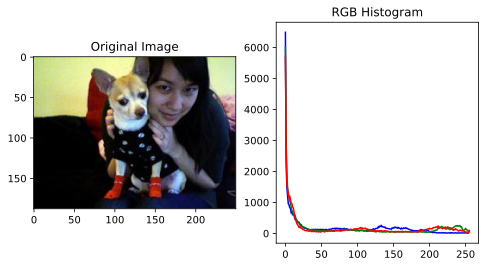

In [113]:
# RGB HISTOGRAM
for class_folder in dog_images_paths:
    image_files = os.listdir(class_folder)

    # Pick one image from each class
    if len(image_files) > 0:
        image_file = image_files[0]
        image_path = os.path.join(class_folder, image_file)

        color_image = cv2.imread(image_path)

        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')

        # Plot the RGB histogram
        plt.subplot(1, 2, 2)
        for channel_idx in range(3):  # 0 for Blue, 1 for Green, 2 for Red
            histogram = cv2.calcHist([color_image], [channel_idx], None, [256], [0, 256])
            plt.plot(histogram, color=['b', 'g', 'r'][channel_idx])
        plt.title('RGB Histogram')

        plt.show()
    else:
        print(f"No images found in folder '{class_folder}'.")



In [114]:
# Histogram comparison (Measure of Similarity and Dissimilarity)

# Function to compute histogram similarity using different distance metrics
def histogram_similarity(hist1, hist2, method):
    if method == 'euclidean':
        return np.linalg.norm(hist1 - hist2)
    elif method == 'manhattan':
        return np.sum(np.abs(hist1 - hist2))
    elif method == 'bhattacharyya':
        return -np.log(np.sum(np.sqrt(hist1 * hist2)))
    elif method == 'intersection':
        return np.sum(np.minimum(hist1, hist2))

# Pick 2 images from the same class and 1 from another class
selected_images = []

for class_folder in dog_images_paths:
    image_files = os.listdir(class_folder)

    if len(image_files) >= 2:
        # Pick 2 images from the same class
        class_images = []
        for i in range(2):
            image_file = image_files[i]
            image_path = os.path.join(class_folder, image_file)
            class_images.append(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))
        selected_images.extend(class_images)
        break


In [115]:
#continuation...
# Pick 1 image from another class
other_class_folder = dog_images_paths[1] if len(dog_images_paths) > 1 else None

if other_class_folder:
    image_files = os.listdir(other_class_folder)
    if len(image_files) >= 1:
        image_file = image_files[0]
        image_path = os.path.join(other_class_folder, image_file)
        selected_images.append(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))

# Calculate histograms for the selected images
histograms = [cv2.calcHist([image], [0], None, [256], [0, 256]) for image in selected_images]

# Perform histogram comparison using different distance metrics
methods = ['euclidean', 'manhattan', 'bhattacharyya', 'intersection']

for method in methods:
    print(f"Using {method} distance:")
    for i in range(len(histograms)):
        for j in range(i + 1, len(histograms)):
            similarity = histogram_similarity(histograms[i], histograms[j], method)
            print(f"Images {i + 1} and {j + 1}: {similarity:.2f}")
    print()


Using euclidean distance:
Images 1 and 2: 5193.68
Images 1 and 3: 7318.12
Images 2 and 3: 8252.91

Using manhattan distance:
Images 1 and 2: 55344.00
Images 1 and 3: 54196.00
Images 2 and 3: 56758.00

Using bhattacharyya distance:
Images 1 and 2: -10.41
Images 1 and 3: -10.41
Images 2 and 3: -10.42

Using intersection distance:
Images 1 and 2: 19003.00
Images 1 and 3: 18452.00
Images 2 and 3: 19746.00



In [122]:
# Plot the selected images
plt.figure(figsize=(8, 4))
for i, (image, histogram) in enumerate(zip(images, histograms), start=1):
    plt.subplot(2, 3, i)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {i}')

    # Plot the intensity histogram
    plt.subplot(2, 3, i + 3)
    plt.plot(histogram)
    plt.title(f'Histogram {i}')

plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

In [130]:
# Image feature descriptor
dog_images_path = '/content/Images/n02085620-Chihuahua/' # using the 2nd class
image_filename = 'n02085620_2981.jpg'
image_path = os.path.join(dog_images_path, image_filename)

img = cv2.imread(image_path)

# Create an ORB object with custom parameters
orb = cv2.ORB_create(edgeThreshold=16, patchSize=30, nlevels=8, fastThreshold=20,
                    scaleFactor=1.2, WTA_K=2, scoreType=cv2.ORB_HARRIS_SCORE,
                    firstLevel=0, nfeatures=30)

# Find the keypoints with ORB
kp = orb.detect(img, None)

# Draw only the keypoints' locations on the image
img2 = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0))

# Display the image with keypoints
cv2.imshow('Image with ORB Keypoints', img2)
cv2.waitKey(2)
cv2.destroyAllWindows()


<Figure size 800x400 with 0 Axes>


In [131]:
# Keypoint extraction

dog_images_path = '/content/Images/n02085620-Chihuahua/'
image_filename = 'n02085620_2981.jpg'
image_path = os.path.join(dog_images_path, image_filename)


img = cv2.imread(image_path)

orb = cv2.ORB_create(nfeatures=50, scaleFactor=1.2, WTA_K=2, scoreType=cv2.ORB_HARRIS_SCORE)
kp = orb.detect(img, None)

# Draw only the keypoints' locations on the image
img_a = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0))

#Finally, Display the image with keypoints
cv2.imshow('Image with ORB Keypoints', img_a)
cv2.waitKey(2)
cv2.destroyAllWindows()

<Figure size 1000x600 with 0 Axes>


In [135]:
# Importing the PCA package
from sklearn.decomposition import PCA

In [ ]:
#Dimensionality Reduction

dog_images_paths = [
    '/content/Images/n02085782-Japanese_spaniel/',
    '/content/Images/n02085620-Chihuahua/'
]

# Function to load images, convert to grayscale, compute histograms, and normalize
def process_images(image_paths):
    images = []
    for path in image_paths:
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            if img is not None:
                # Compute the histogram
                hist = cv2.calcHist([img], [0], None, [256], [0, 256])
                # Normalize the histogram
                hist = hist / np.sum(hist)
                images.append(hist.flatten())  # Flatten the histogram
    return np.array(images)

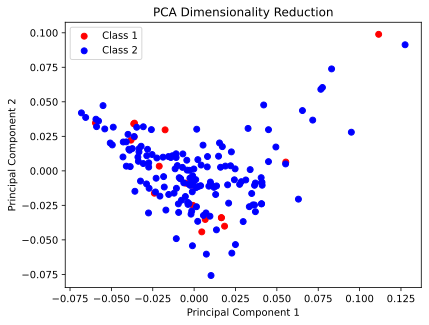

In [143]:
# Process images for the two classes
class_1_images = process_images([dog_images_paths[0]])
class_2_images = process_images([dog_images_paths[1]])

# Combine the two classes into a single dataset
dataset = np.vstack((class_1_images, class_2_images))

# Apply PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(dataset)

# Plot the 2D points with different colors for the two classes
plt.scatter(reduced_data[:len(class_1_images), 0], reduced_data[:len(class_1_images), 1], label='Class 1', c='red')
plt.scatter(reduced_data[len(class_1_images):, 0], reduced_data[len(class_1_images):, 1], label='Class 2', c='blue')
plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Dimensionality Reduction')
plt.show()
